In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os
from skimage.measure import label,regionprops_table
import pandas as pd
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
ran_color=True
min_radi=32
image_size=10000
num_circles = 5000
max_radi=3000

if ran_color:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_cl_std_000/'
else:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_bw/'
if not os.path.exists(Dir[:-1]):
    os.makedirs(Dir[:-1])
    os.makedirs(Dir+'img')
    os.makedirs(Dir+'msk')
    os.makedirs(Dir + 'zht')
for i in range(1):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    mask = np.zeros((image_size, image_size), dtype=np.uint16)
    height_image = np.zeros((image_size, image_size), dtype=np.float32)

    circles = []

    for circle_id in range(1, num_circles + 1):
        max_attempts = 100  # Limit the number of attempts to find a non-overlapping position
        for attempt in range(max_attempts):
            radius = random.randint(min_radi, max_radi)
            center_x = random.randint(radius, image_size - radius)
            center_y = random.randint(radius, image_size - radius)
            center = (center_x, center_y)

            # Check for overlap with existing circles
            overlap = False
            for (existing_center, existing_radius) in circles:
                dist = np.sqrt((center_x - existing_center[0]) ** 2 + (center_y - existing_center[1]) ** 2)
                if dist < radius + existing_radius + 1:#+1 so that no contact between circles
                    overlap = True
                    break

            if not overlap:
                circles.append((center, radius))
                
                if ran_color:
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                else:
                    color = (255,255,255)
                cv2.circle(image, center, radius, color, -1)
                
                cv2.circle(mask, center, radius, circle_id, -1)
                y1, y2 = center_y - radius, center_y + radius
                
                #DEM
                x1, x2 = center_x - radius, center_x + radius

                if x1 < 0 or y1 < 0 or x2 >= image_size or y2 >= image_size:
                    continue

                yy, xx = np.meshgrid(np.arange(y1, y2), np.arange(x1, x2), indexing='ij')
                dx = xx - center_x
                dy = yy - center_y
                dist_sq = dx**2 + dy**2
                mask_circle = dist_sq <= radius**2

                z = np.zeros_like(dist_sq, dtype=np.float32)
                z[mask_circle] = np.sqrt(radius**2 - dist_sq[mask_circle])

                height_image[y1:y2, x1:x2] = np.maximum(height_image[y1:y2, x1:x2], z)
                break  

    #np.save(Dir+f'img/img_{i:02}',image)
    #np.save(Dir+f'msk/msk_{i:02}',mask)


In [3]:
def cdf(data, title_label, xlabel, label=''):

    data = np.sort(data)
    cdf = np.arange(1, len(data) + 1) / len(data)
    plt.plot(data, cdf, label=label)


    plt.title(title_label, fontsize=20)
    plt.xscale("log")
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Cumulative Probability", fontsize=16)        
    plt.grid(True)

In [4]:
def add_gaussian_noise_to_circle(array, mean ,std , mask=None, edge_std=None):
    '''
    add gaussian noise to the input image. if mask is given noise will not be added to the area outside the circle. if edge_std is given, different noise will be applied to the edge. mask is required for that.
    '''
    gaussian_noise = np.random.normal(mean, std, array.shape)
    if np.any(mask):
        mask=mask>0
        gaussian_noise=gaussian_noise*mask[:, :, np.newaxis]
        if edge_std:
            gaussian_noise_ed = np.random.normal(mean, edge_std, array.shape)
            gaussian_noise+=gaussian_noise_ed*~mask[:, :, np.newaxis]
    noisy_image = array.astype(float) + gaussian_noise
    #noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def compute_hillshade(z, azimuth=315, altitude=45, z_factor=1.0):
    azimuth_rad = np.radians(azimuth)
    altitude_rad = np.radians(altitude)

    dzdx = np.gradient(z, axis=1)
    dzdy = np.gradient(z, axis=0)

    slope_rad = np.arctan(z_factor * np.sqrt(dzdx**2 + dzdy**2))
    aspect_rad = np.arctan2(dzdy, -dzdx)

    shaded = (np.sin(altitude_rad) * np.cos(slope_rad) + np.cos(altitude_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad))

    #shaded = np.clip(shaded, 0, 1)
    #shaded = (shaded * 255).astype(np.uint8)

    return shaded

In [8]:
noisy_height=add_gaussian_noise_to_circle(height_image,0,3)

noisy_height = np.clip(noisy_height, a_min=0,a_max=None)

hillshade = compute_hillshade(noisy_height, azimuth=135, altitude=60)
hillshade = np.clip(hillshade, 0, 1)

hillshade_3ch = np.stack([hillshade]*3, axis=-1)  
image_shadow = (image.astype(np.float32) * hillshade_3ch).astype(np.uint8)

In [6]:
from scipy.ndimage import shift

def shift_image(img, dx, dy):
    """Shift the image using interpolation."""
    return shift(img, (dy, dx), mode='constant', cval=0.0)

def calculate_shadow_mask(height_map, light_dir, max_steps=1000):
    """
    Calculate shadow mask for a height map with parallel light from a given direction.
    
    Parameters:
        height_map (numpy.ndarray): 2D array of heights.
        light_dir (tuple): Direction of the light as a (dx, dy) tuple. 
                           Example: (1, 0) for light coming from the right.
        max_steps (int): Maximum steps to check for occluders.
    
    Returns:
        numpy.ndarray: Boolean mask where True indicates shadowed pixels.
    """
    dx = -light_dir[0]
    dy = -light_dir[1]
    
    accumulated_max = height_map.copy()
    for _ in range(max_steps):
        shifted = shift_image(accumulated_max, dx, dy)
        new_max = np.maximum(accumulated_max, shifted)
        if np.array_equal(new_max, accumulated_max):
            break
        accumulated_max = new_max
    shadow_mask = height_map < accumulated_max
    return shadow_mask

def apply_shadow_to_rgb(rgb_image, shadow_mask, shadow_strength=0.5):
    """
    Apply shadow effect to an RGB image based on the shadow mask.
    
    Parameters:
        rgb_image (numpy.ndarray): 3-channel RGB image.
        shadow_mask (numpy.ndarray): Boolean mask where True indicates shadow.
        shadow_strength (float): Darkness factor (0.0 to 1.0).
    
    Returns:
        numpy.ndarray: Shadowed RGB image.
    """
    shadowed = rgb_image.copy().astype(np.float32)
    shadowed[shadow_mask] *= shadow_strength
    shadowed = np.clip(shadowed, 0, 255).astype(np.uint8)
    return shadowed
def compute_light_dir(azimuth_deg, altitude_deg):
    """
    Compute light direction (dx, dy) for shadow casting.
    Azimuth: clockwise from north (0°=north, 90°=east).
    Altitude: angle above the horizon (0°=horizontal, 90°=overhead).
    """
    azimuth_rad = np.deg2rad(azimuth_deg)
    altitude_rad = np.deg2rad(altitude_deg)
    
    # Direction vector components (unit vector)
    dx = np.sin(azimuth_rad)  # East-west component
    dy = np.cos(azimuth_rad)  # North-south component
    
    # Adjust dy for image coordinates (north is upward, so invert dy)
    dy = -dy
    
    # Scale by cot(altitude) to account for shadow length
    scale = 1 / np.tan(altitude_rad)
    dx_scaled = dx * scale
    dy_scaled = dy * scale
    
    return (dx_scaled, dy_scaled)


azimuth = 315
altitude = 60
light_dir = compute_light_dir(azimuth, altitude)
shadow_mask = calculate_shadow_mask(noisy_height, light_dir)
shadowed_rgb = apply_shadow_to_rgb(image, shadow_mask, shadow_strength=0.3)

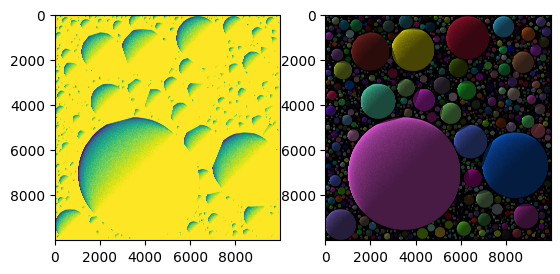

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(shadow_mask)
plt.subplot(1,2,2)
plt.imshow(shadowed_rgb)

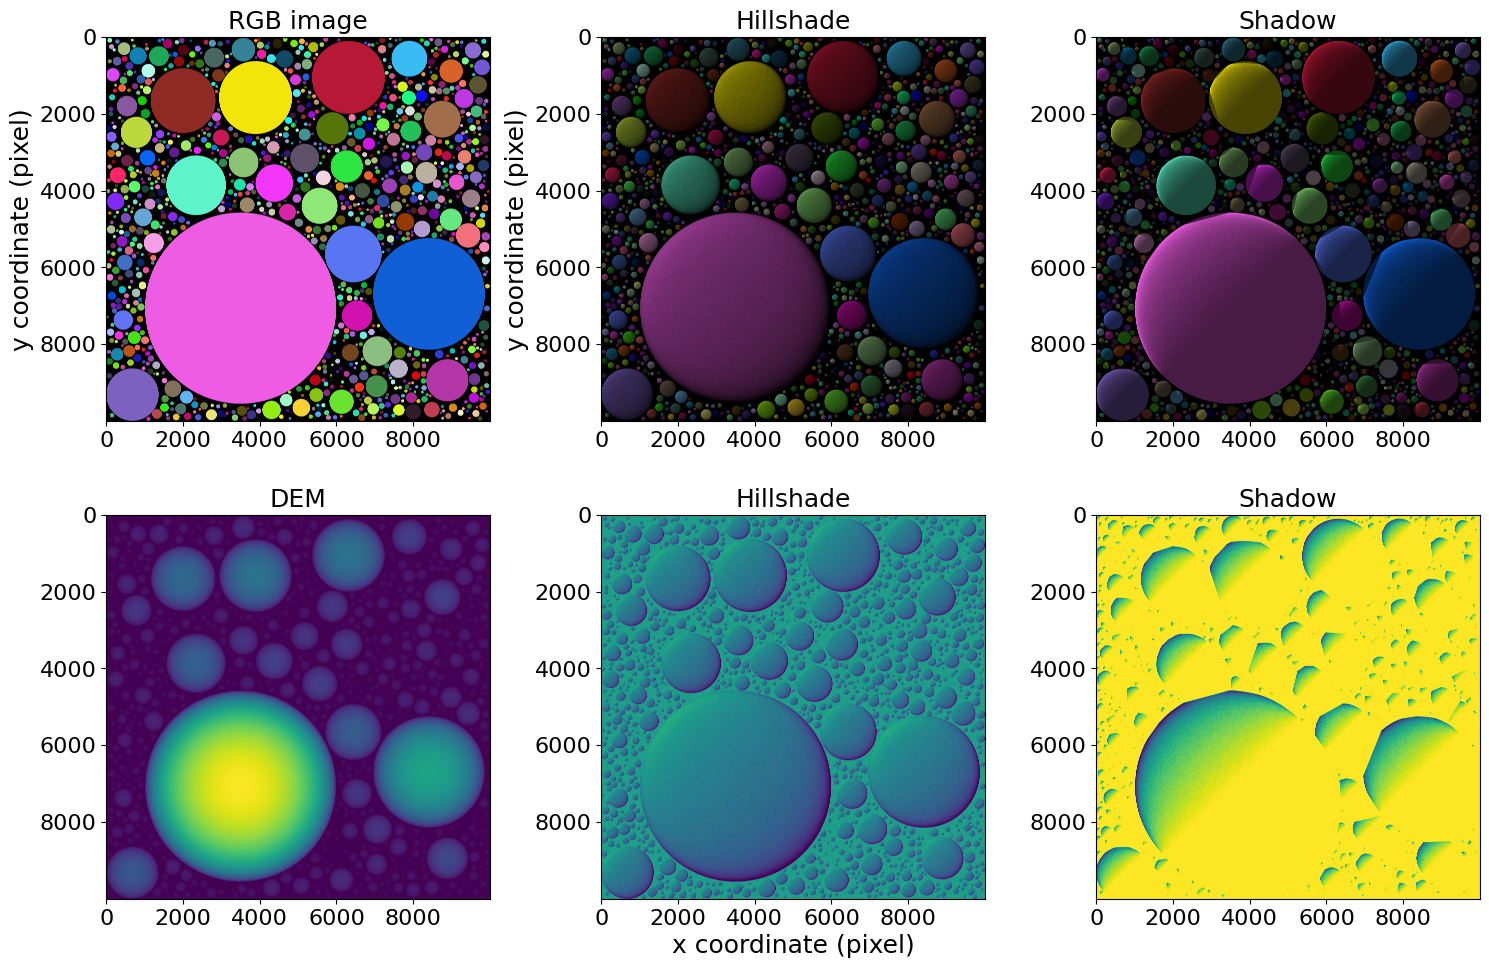

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(image)
plt.title('RGB image', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.subplot(2,3,4)
plt.imshow(noisy_height)
plt.title('DEM', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(2,3,2)
plt.imshow(image_shadow)
#plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.title('Hillshade', fontsize=18)
plt.subplot(2,3,5)
plt.imshow(hillshade)
#plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("x coordinate (pixel)", fontsize=18)
plt.title('Hillshade', fontsize=18)
plt.subplot(2,3,3)
plt.imshow(shadowed_rgb)
plt.title('Shadow', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(2,3,6)
plt.imshow(shadow_mask)
plt.title('Shadow', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
labeled=label(mask, background=0)
props = regionprops_table(
    labeled,
    properties=('axis_major_length', 'area'),
)
props_df=pd.DataFrame(props)

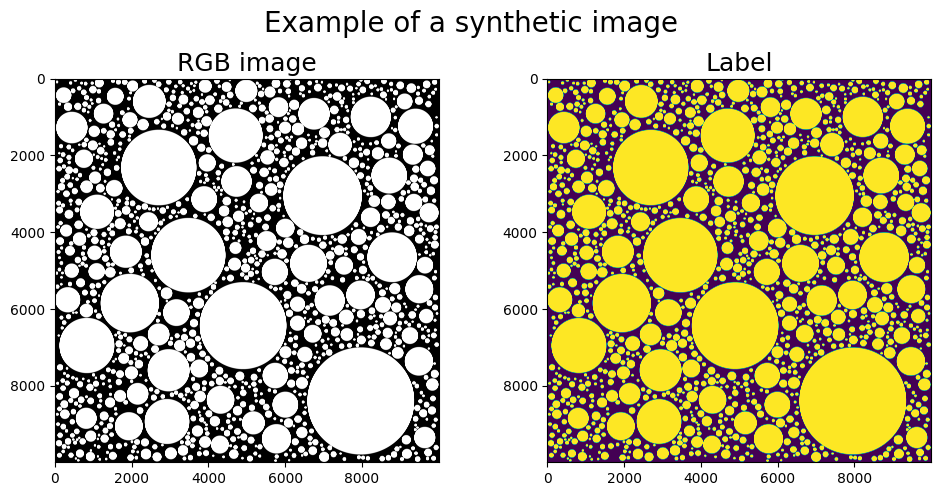

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(image)
#plt.title('RGB image', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.xlabel("x coordinate (pixel)", fontsize=18)
plt.subplot(1,2,2)
#plt.imshow(mask>0)
#plt.title('Label', fontsize=18)
#plt.subplot(1,2,3)
cdf(props_df['area'], '', 'Area (pixels)',f'Size distribution (n = {len(np.unique(mask)-1)})')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.suptitle('Example of a synthetic image', fontsize=20)
plt.tight_layout()#rect=[0, 0.03, 1, 0.98])
#plt.savefig('figure/example_syn_img.png')


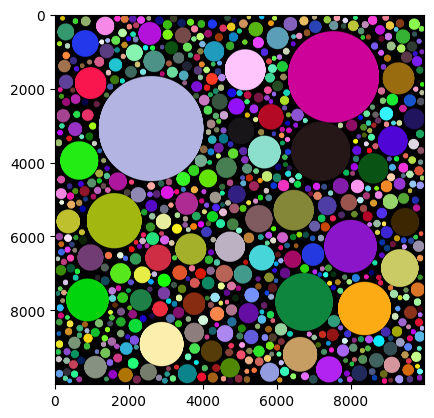

In [8]:
plt.imshow(np.load('/DATA/vito/data/ran_synth_64_cl_std_00/img/img_00.npy'))